<a href="https://colab.research.google.com/github/vshalisko/PythonIntro/blob/main/Unidad_3/Proyecto_5_borrador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Cargar datos

In [88]:
import pandas as pd
ruta_archivo = '/content/drive/MyDrive/Colab Data/house_class.csv'
df = pd.read_csv(ruta_archivo)
df

,Price,Area,Room,Lon,Lat,Zip_area,Zip_loc
0,0,64,3,4.907736,52.356157,10,CR
1,0,60,3,4.850476,52.348586,10,EL
2,1,109,4,4.944774,52.343782,10,SM
3,0,128,6,4.789928,52.343712,10,TH
4,1,138,5,4.902503,52.410538,10,KN
...,...,...,...,...,...,...,...
909,1,117,1,4.927757,52.354173,10,AE
910,0,72,3,4.890612,52.414587,10,CP
911,0,51,3,4.856935,52.363256,10,AK
912,0,113,4,4.965731,52.375268,10,MB


### Explorar caracteristicas de datos

In [94]:
print("Tamaño dataframe:", df.shape)
print("Presencia de lineas sin datos:", df.isnull().values.any())
print("Máximo de cuartos:", df.loc[:,['Room']].max().item())
print("Promedio de área:", round(df.loc[:, ['Area']].mean().item(),1))
print("Precio únicos:", df.loc[:, ['Price']].nunique().item())
print("Zip_area únicos:", df.loc[:, ['Zip_area']].nunique().item())
print("Zip_loc únicos:", df.loc[:, ['Zip_loc']].nunique().item())

Tamaño dataframe: (914, 7)
Presencia de lineas sin datos: False
Máximo de cuartos: 9
Promedio de área: 93.2
Precio únicos: 2
Zip_area únicos: 2
Zip_loc únicos: 239


In [95]:
display(df[['Area','Room','Lon','Lat']].describe())

,Area,Room,Lon,Lat
count,914.000000,914.000000,914.000000,914.000000
mean,93.185996,3.506565,4.888632,52.363218
std,47.574078,1.398035,0.053150,0.024076
min,21.000000,1.000000,4.644819,52.291519
25%,60.000000,3.000000,4.855833,52.351815
50%,82.000000,3.000000,4.886454,52.364362
75%,111.000000,4.000000,4.922579,52.377549
max,374.000000,9.000000,5.029122,52.423805


### Visualizar datos

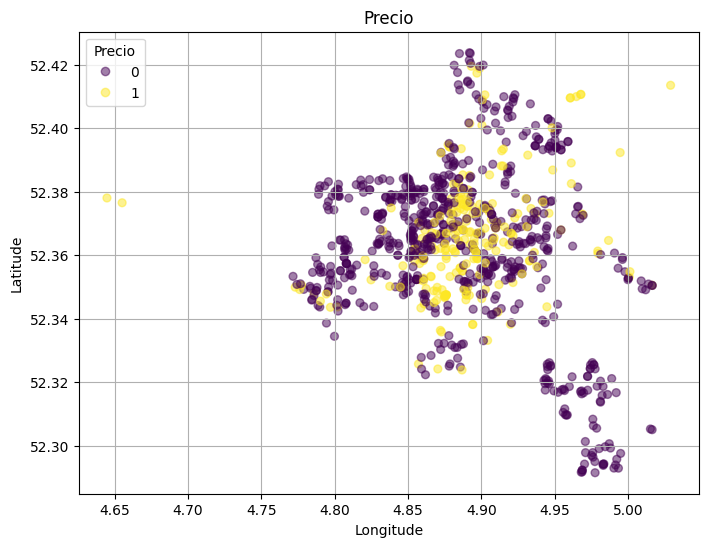

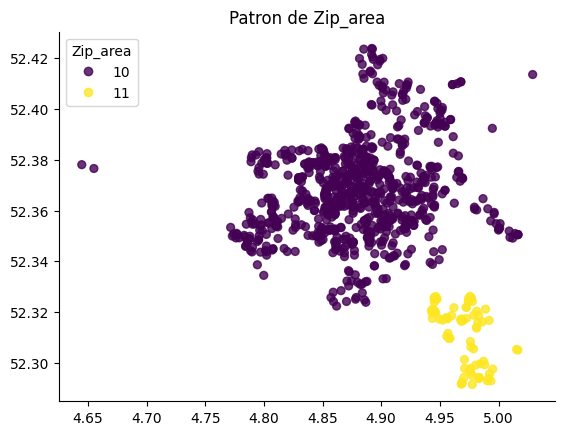

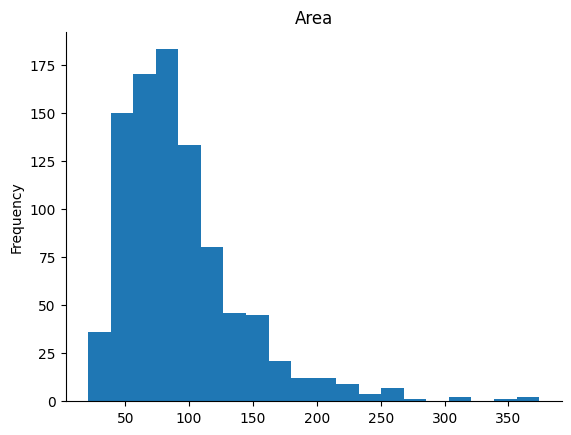

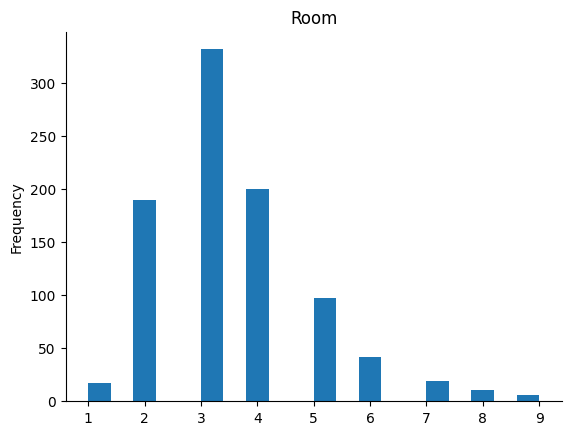

In [96]:
from matplotlib import pyplot as plt

levels_p, categories_p = pd.factorize(df['Price'])
plt.figure(figsize=(8, 6))
scatter_p = plt.scatter(x='Lon', y='Lat', data=df,
                      c=levels_p, s=32, alpha=.5)
plt.title('Precio')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(scatter_p.legend_elements()[0], categories_p, title='Precio')
plt.show()

levels_a, categories_a = pd.factorize(df['Zip_area'])
scatter_a = plt.scatter(x='Lon', y='Lat', data=df,
                      c=levels_a, s=32, alpha=.8)
plt.legend(scatter_a.legend_elements()[0], categories_a, title='Zip_area')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Patron de Zip_area')
plt.show()

df['Area'].plot(kind='hist', bins=20, title='Area')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

df['Room'].plot(kind='hist', bins=20, title='Room')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()






### Preparar datos para proceso de clasificación

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

X = df.loc[:, ['Area','Room','Lon','Lat','Zip_area','Zip_loc']]
y = df.loc[:, ['Price']]

enc = OrdinalEncoder()
enc.fit(X[['Zip_area', 'Zip_loc']])

X_transformed = pd.DataFrame(enc.transform(X[['Zip_area', 'Zip_loc']]),
                                       index=X.index)

X_full = X[['Area', 'Room', 'Lon', 'Lat']].join(X_transformed)

X_train, X_test, y_train, y_test = train_test_split(X_full.values, y.values,
                         stratify=X['Zip_loc'].values,
                         train_size=0.7, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(639, 6)
(275, 6)
(639, 1)
(275, 1)


### Entrenar y evaluar el modelo de clasificación (Decision Tree)

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

dtree = DecisionTreeClassifier(criterion='entropy', max_features=3, splitter='best',
                                     max_depth=6, min_samples_split=4, random_state=3)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)

print("Precisión: {}".format(round(report['accuracy'], 3)))
print("F1 score: {}".format(round(report['macro avg']['f1-score'], 3)))

Precisión: 0.895
F1 score: 0.865


### Visualizar la predicción del modelo

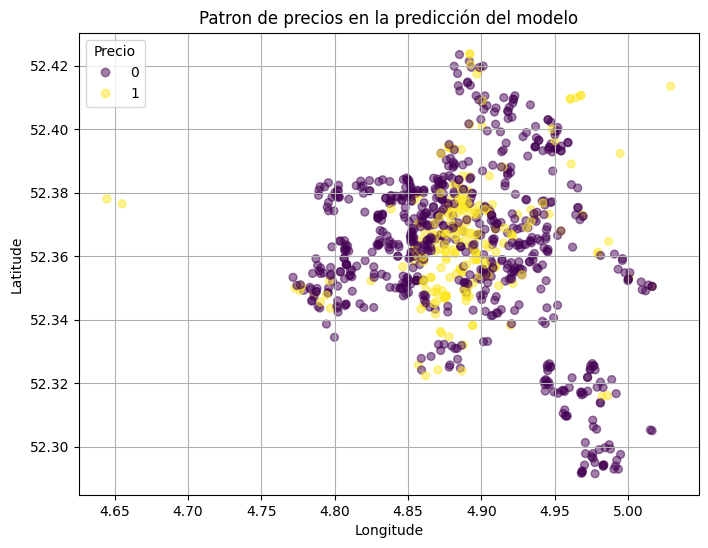

In [100]:
y_pred_full = dtree.predict(X_full.values)
levels_predict, categories_predict = pd.factorize(y_pred_full)

plt.figure(figsize=(8, 6))
scatter_predict = plt.scatter(x='Lon', y='Lat', data=df,
                      c=levels_predict, s=32, alpha=.5)
plt.title('Patron de precios en la predicción del modelo')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(scatter_predict.legend_elements()[0], categories_predict, title='Precio')
plt.show()

### Visualizar la diferencia entre predicciones del modelo y la realidad

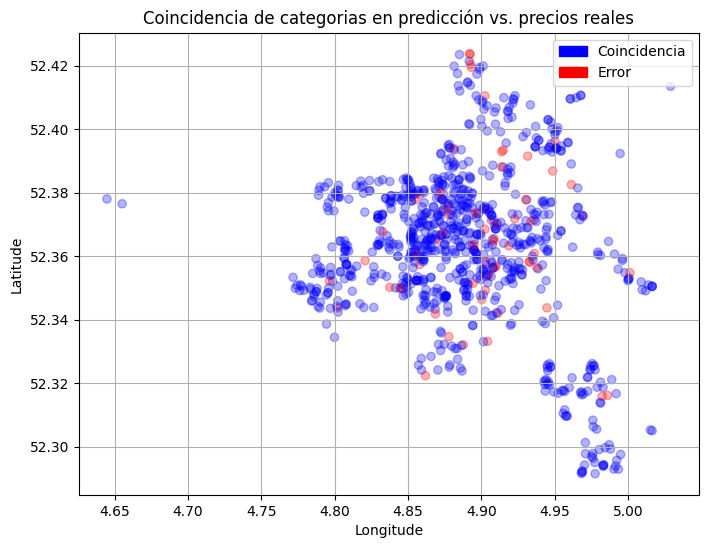

In [104]:
# Crear mascara binaria de coincidencias
matches = (y_pred_full == y.values.flatten())

# asignar colores
colors = ['blue' if m else 'red' for m in matches]

plt.figure(figsize=(8, 6))
plt.scatter(df['Lon'], df['Lat'], c=colors, alpha=0.3)
plt.title('Coincidencia de categorias en predicción vs. precios reales')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Agregar leyenda manual
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='blue', label='Coincidencia')
blue_patch = mpatches.Patch(color='red', label='Error')
plt.legend(handles=[red_patch, blue_patch])

plt.show()